In theory, this notebook will be the comprehensive source code for downloading GOES and VIIRS data necessary for the bulk of the UNet. It will need to be supplanted with LANDFIRE data, which ideally will be able to downloaded via an API.

In [1]:
import xarray as xr
import rioxarray
import boto3
from botocore.config import Config
from botocore import UNSIGNED
from datetime import datetime
import requests
import netCDF4

# Download GOES data and save as GEOTIFF

In [307]:
bucket_name = 'noaa-goes16'
product_name = 'ABI-L2-MCMIPC'


year = 2021
day_of_year = 79
hour = 14
band = 3

In [308]:
s3_client = boto3.client('s3', config=Config(signature_version=UNSIGNED))


The following workflow comes mostly from this source:

https://github.com/HamedAlemo/visualize-goes16/blob/master/visualize_GOES16_from_AWS.ipynb

### For now, we only want GOES data that is associated with VIIRS observations

First define a helper function that returns the doy / hour of any given GOES observation from key:

In [309]:
def get_date_hour(single_key, return_doy = True):
    
    '''
    single_key (str): key string returned from get_s3_keys
    return_doy (boolean): if True, returns day of year
                    if False, returns date
    '''
    
    doy, hour = single_key.split('/')[2], single_key.split('/')[3]
    date = str(datetime.strptime('2020'+'-' + doy, "%Y-%j"))[:10] 

    
    if return_doy == True:
        return int(doy), int(hour)
    
    else:
        return date, str(hour)




Then, read in viirs data and extract the doy, hour of each observation.

In [310]:
import pandas as pd
viirs = pd.read_csv('../Data/VIIRS/concactenated_viirs.csv', parse_dates = ['date_time'])
viirs['hour'] = viirs.date_time.dt.hour
viirs_doy, viirs_hour_dict = viirs.doy.unique().tolist(), viirs.groupby('doy')['hour'].unique().apply(list).to_dict()


Now, define a function that accesses AWS servers, only pulling data that is found with the correct date and time

In [311]:
def get_s3_keys(bucket, s3_client, prefix = '', doy_list = [], hour_dict = []):
    """
    Generate the keys in an S3 bucket.

    :param bucket: Name of the S3 bucket.
    :param prefix: Only fetch keys that start with this prefix (optional).
    """
    
    kwargs = {'Bucket': bucket}

    if isinstance(prefix, str):
        kwargs['Prefix'] = prefix

    while True:
        resp = s3_client.list_objects_v2(**kwargs)
        for obj in resp['Contents']:
            key = obj['Key']
            
            # Grab doy and hour from the key
            doy, hour = get_date_hour(key, return_doy=True)
            
            if key.startswith(prefix):
                
                # Also, if key is associated with a VIIRS observation
                if doy in doy_list:
                    hour_list = hour_dict[doy]
                    
                    if hour in hour_list:
                        yield key

        try:
            kwargs['ContinuationToken'] = resp['NextContinuationToken']
        except KeyError:
            break

## Generate s3 keys

In [312]:
# year = 2022
# day_of_year = 79
# hour = 14
# band = 3

In [313]:
keys = get_s3_keys(bucket_name,
                   s3_client,
                   prefix = f'{product_name}/{year}',
                   doy_list = viirs_doy,
                   hour_dict = viirs_hour_dict
#                    /{day_of_year:03.0f}/{hour:02.0f}/OR_{product_name}-M6'
                  )

key = [key for key in keys]

# TO DO:
- Figure out how to pull old VIIRS data and not the most recent stuff
- Extract date / time from DS object instead of the key string
    - Write in extraction into write_tif, modifying it to take a generator object that consists of a list of DS's
- Pray that the computer doesn't catch on fire :)

Now, we can send a request to AWS servers to pull the .nc files

In [314]:
def loop_keys(key_list):
    for k in key_list:      

        # Send reques
        resp = requests.get(f'https://{bucket_name}.s3.amazonaws.com/{k}')

        nc4_ds = netCDF4.Dataset(fname, memory = resp.content)
        store = xr.backends.NetCDF4DataStore(nc4_ds)
        DS = xr.open_dataset(store)
        
        yield DS
    

In [385]:
f'https://{bucket_name}.s3.amazonaws.com/{key[-1]}'

'https://noaa-goes16.s3.amazonaws.com/ABI-L2-MCMIPC/2021/131/12/OR_ABI-L2-MCMIPC-M6_G16_s20211311256161_e20211311258545_c20211311259027.nc'

In [433]:
date, hour = get_date_hour(key[-1], return_doy=False)
        
        
fname = "LST_" + date + "_" + hour

resp = requests.get(f'https://{bucket_name}.s3.amazonaws.com/{key[-1]}')

nc4_ds = netCDF4.Dataset(fname, memory = resp.content)

print(nc4_ds)

# DS = xr.open_dataset(nc4_ds)
store = xr.backends.NetCDF4DataStore(nc4_ds)
DS = xr.open_dataset(store)

<class 'netCDF4._netCDF4.Dataset'>
root group (NETCDF4 data model, file format HDF5):
    naming_authority: gov.nesdis.noaa
    Conventions: CF-1.7
    Metadata_Conventions: Unidata Dataset Discovery v1.0
    standard_name_vocabulary: CF Standard Name Table (v35, 20 July 2016)
    institution: DOC/NOAA/NESDIS > U.S. Department of Commerce, National Oceanic and Atmospheric Administration, National Environmental Satellite, Data, and Information Services
    project: GOES
    production_site: NSOF
    production_environment: OE
    spatial_resolution: 2km at nadir
    orbital_slot: GOES-East
    platform_ID: G16
    instrument_type: GOES R Series Advanced Baseline Imager
    scene_id: CONUS
    instrument_ID: FM1
    dataset_name: OR_ABI-L2-MCMIPC-M6_G16_s20211311256161_e20211311258545_c20211311259027.nc
    iso_series_metadata_id: 8c9e8150-3692-11e3-aa6e-0800200c9a66
    keywords_vocabulary: NASA Global Change Master Directory (GCMD) Earth Science Keywords, Version 7.0.0.0.0
    title: A

In [ ]:
# See if I need to cast xarray to np array in order to export

# Think about why I'm using LST as opposed to some other product

# Try pulling MCMIPC products :)

# Consider using L1 products

# See if I can find CRS information within the DS / nc4 objects

# Letter rip!

In [386]:
good_path = '../../Downloads/OR_ABI-L2-MCMIPC-M6_G16_s20211311256161_e20211311258545_c20211311259027.nc'

In [387]:
good_DS = rioxarray.open_rasterio(good_path)

In [388]:
good_DS.rio.crs

ERROR 1: PROJ: proj_identify: /Users/seancarter/opt/miniconda3/envs/work/share/proj/proj.db lacks DATABASE.LAYOUT.VERSION.MAJOR / DATABASE.LAYOUT.VERSION.MINOR metadata. It comes from another PROJ installation.


CRS.from_wkt('PROJCS["unnamed",GEOGCS["unknown",DATUM["unnamed",SPHEROID["Spheroid",6378137,298.2572221]],PRIMEM["Greenwich",0],UNIT["degree",0.0174532925199433,AUTHORITY["EPSG","9122"]]],PROJECTION["Geostationary_Satellite"],PARAMETER["central_meridian",-75],PARAMETER["satellite_height",35786023],PARAMETER["false_easting",0],PARAMETER["false_northing",0],UNIT["metre",1,AUTHORITY["EPSG","9001"]],AXIS["Easting",EAST],AXIS["Northing",NORTH],EXTENSION["PROJ4","+proj=geos +lon_0=-75 +h=35786023 +x_0=0 +y_0=0 +ellps=GRS80 +units=m +no_defs +sweep=x"]]')

In [382]:
crs = str(good_DS.rio.crs)

ERROR 1: PROJ: proj_identify: /Users/seancarter/opt/miniconda3/envs/work/share/proj/proj.db lacks DATABASE.LAYOUT.VERSION.MAJOR / DATABASE.LAYOUT.VERSION.MINOR metadata. It comes from another PROJ installation.


In [411]:
good_DS.goes_imager_projection

<xarray.DataArray 'goes_imager_projection' ()>
array(0)
Coordinates:
    goes_imager_projection  int64 0
Attributes:
    crs_wkt:                         PROJCS["unnamed",GEOGCS["unknown",DATUM[...
    semi_major_axis:                 6378137.0
    semi_minor_axis:                 6356752.314140284
    inverse_flattening:              298.2572221
    reference_ellipsoid_name:        Spheroid
    longitude_of_prime_meridian:     0.0
    prime_meridian_name:             Greenwich
    geographic_crs_name:             unknown
    horizontal_datum_name:           unnamed
    projected_crs_name:              unnamed
    grid_mapping_name:               geostationary
    sweep_angle_axis:                x
    perspective_point_height:        35786023.0
    latitude_of_projection_origin:   0.0
    longitude_of_projection_origin:  -75.0
    false_easting:                   0.0
    false_northing:                  0.0
    spatial_ref:                     PROJCS["unnamed",GEOGCS["unknown",DATUM[...
    GeoTransform:                    -3627271.340967355 2004.017315487541 0.0...

In [434]:
DS.attrs

{'naming_authority': 'gov.nesdis.noaa',
 'Conventions': 'CF-1.7',
 'Metadata_Conventions': 'Unidata Dataset Discovery v1.0',
 'standard_name_vocabulary': 'CF Standard Name Table (v35, 20 July 2016)',
 'institution': 'DOC/NOAA/NESDIS > U.S. Department of Commerce, National Oceanic and Atmospheric Administration, National Environmental Satellite, Data, and Information Services',
 'project': 'GOES',
 'production_site': 'NSOF',
 'production_environment': 'OE',
 'spatial_resolution': '2km at nadir',
 'orbital_slot': 'GOES-East',
 'platform_ID': 'G16',
 'instrument_type': 'GOES R Series Advanced Baseline Imager',
 'scene_id': 'CONUS',
 'instrument_ID': 'FM1',
 'dataset_name': 'OR_ABI-L2-MCMIPC-M6_G16_s20211311256161_e20211311258545_c20211311259027.nc',
 'iso_series_metadata_id': '8c9e8150-3692-11e3-aa6e-0800200c9a66',
 'keywords_vocabulary': 'NASA Global Change Master Directory (GCMD) Earth Science Keywords, Version 7.0.0.0.0',
 'title': 'ABI L2 Cloud and Moisture Imagery',
 'summary': 'Mult

In [427]:
set_coords_dict = {'goes_imager_projection':good_DS.goes_imager_projection}
DS = DS.assign_coords(set_coords_dict)





In [432]:
DS.goes_imager_projection






<xarray.DataArray 'goes_imager_projection' ()>
array(0)
Coordinates:
    t                       datetime64[ns] 2021-05-11T12:57:35.369501952
    goes_imager_projection  int64 0
    y_image                 float32 0.08624
    x_image                 float32 -0.03136
Attributes:
    crs_wkt:                         PROJCS["unnamed",GEOGCS["unknown",DATUM[...
    semi_major_axis:                 6378137.0
    semi_minor_axis:                 6356752.314140284
    inverse_flattening:              298.2572221
    reference_ellipsoid_name:        Spheroid
    longitude_of_prime_meridian:     0.0
    prime_meridian_name:             Greenwich
    geographic_crs_name:             unknown
    horizontal_datum_name:           unnamed
    projected_crs_name:              unnamed
    grid_mapping_name:               geostationary
    sweep_angle_axis:                x
    perspective_point_height:        35786023.0
    latitude_of_projection_origin:   0.0
    longitude_of_projection_origin:  -75.0
    false_easting:                   0.0
    false_northing:                  0.0
    spatial_ref:                     PROJCS["unnamed",GEOGCS["unknown",DATUM[...
    GeoTransform:                    -3627271.340967355 2004.017315487541 0.0...

In [436]:
test = DS.get(['CMI_C01', 'CMI_C02'])

test.attrs = DS.attrs
# test.rio.write_crs(DS.goes_imager_projection.crs_wkt, inplace=True)




In [437]:
test.rio.to_raster('../Data/GOES/'+ 'test2' + '.tif')

In [357]:
type(good_DS)

xarray.core.dataset.Dataset

In [335]:
DS['CMI_C01'].values

array([[       nan,        nan,        nan, ..., 0.385079  , 0.3841266 ,
        0.44666624],
       [       nan,        nan,        nan, ..., 0.41809484, 0.39999962,
        0.46857098],
       [       nan,        nan,        nan, ..., 0.39269805, 0.40444407,
        0.39396787],
       ...,
       [0.00253968, 0.00253968, 0.00253968, ..., 0.18761887, 0.16952364,
        0.18031728],
       [0.00253968, 0.00253968, 0.00253968, ..., 0.10539673, 0.1253967 ,
        0.17841253],
       [0.00253968, 0.00253968, 0.00253968, ..., 0.08825389, 0.13142845,
        0.20158711]], dtype=float32)

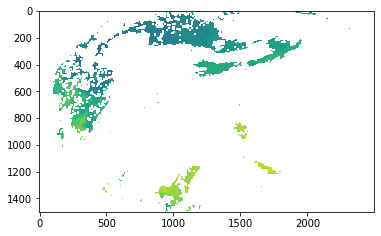

In [300]:
import matplotlib.pyplot as plt
plt.imshow(DS['LST'].values)
# plt.imshow(DS.Rad, cmap='gray')

In [318]:
DS2 = DS.Rad*1

sum(np.isnan(DS2.values))

AttributeError: 'Dataset' object has no attribute 'Rad'

In [320]:
DS.rio.to_raster('../Data/GOES/'+ 'test' + '.tif')


TypeError: The DType <class 'numpy.dtype[datetime64]'> could not be promoted by <class 'numpy.dtype[float64]'>. This means that no common DType exists for the given inputs. For example they cannot be stored in a single array unless the dtype is `object`. The full list of DTypes is: (<class 'numpy.dtype[float32]'>, <class 'numpy.dtype[float32]'>, <class 'numpy.dtype[float32]'>, <class 'numpy.dtype[float32]'>, <class 'numpy.dtype[float32]'>, <class 'numpy.dtype[float32]'>, <class 'numpy.dtype[float32]'>, <class 'numpy.dtype[float32]'>, <class 'numpy.dtype[float32]'>, <class 'numpy.dtype[float32]'>, <class 'numpy.dtype[float32]'>, <class 'numpy.dtype[float32]'>, <class 'numpy.dtype[float32]'>, <class 'numpy.dtype[float32]'>, <class 'numpy.dtype[float32]'>, <class 'numpy.dtype[float32]'>, <class 'numpy.dtype[float32]'>, <class 'numpy.dtype[float32]'>, <class 'numpy.dtype[float32]'>, <class 'numpy.dtype[float32]'>, <class 'numpy.dtype[float32]'>, <class 'numpy.dtype[float32]'>, <class 'numpy.dtype[float32]'>, <class 'numpy.dtype[float32]'>, <class 'numpy.dtype[float32]'>, <class 'numpy.dtype[float32]'>, <class 'numpy.dtype[float32]'>, <class 'numpy.dtype[float32]'>, <class 'numpy.dtype[float32]'>, <class 'numpy.dtype[float32]'>, <class 'numpy.dtype[float32]'>, <class 'numpy.dtype[float32]'>, <class 'numpy.dtype[datetime64]'>, <class 'numpy.dtype[int32]'>, <class 'numpy.dtype[float32]'>, <class 'numpy.dtype[float32]'>, <class 'numpy.dtype[float64]'>, <class 'numpy.dtype[float64]'>, <class 'numpy.dtype[float64]'>, <class 'numpy.dtype[float32]'>, <class 'numpy.dtype[float64]'>, <class 'numpy.dtype[float64]'>, <class 'numpy.dtype[float64]'>, <class 'numpy.dtype[float64]'>, <class 'numpy.dtype[float64]'>, <class 'numpy.dtype[float64]'>, <class 'numpy.dtype[float64]'>, <class 'numpy.dtype[float64]'>, <class 'numpy.dtype[float64]'>, <class 'numpy.dtype[float64]'>, <class 'numpy.dtype[float64]'>, <class 'numpy.dtype[float64]'>, <class 'numpy.dtype[float64]'>, <class 'numpy.dtype[float64]'>, <class 'numpy.dtype[float64]'>, <class 'numpy.dtype[float64]'>, <class 'numpy.dtype[float64]'>, <class 'numpy.dtype[float64]'>, <class 'numpy.dtype[float64]'>, <class 'numpy.dtype[float64]'>, <class 'numpy.dtype[float64]'>, <class 'numpy.dtype[float64]'>, <class 'numpy.dtype[float64]'>, <class 'numpy.dtype[float64]'>, <class 'numpy.dtype[float64]'>, <class 'numpy.dtype[float64]'>, <class 'numpy.dtype[float64]'>, <class 'numpy.dtype[float64]'>, <class 'numpy.dtype[float64]'>, <class 'numpy.dtype[float64]'>, <class 'numpy.dtype[float64]'>, <class 'numpy.dtype[float64]'>, <class 'numpy.dtype[float64]'>, <class 'numpy.dtype[float64]'>, <class 'numpy.dtype[float64]'>, <class 'numpy.dtype[float64]'>, <class 'numpy.dtype[float64]'>, <class 'numpy.dtype[float64]'>, <class 'numpy.dtype[float64]'>, <class 'numpy.dtype[float64]'>, <class 'numpy.dtype[float64]'>, <class 'numpy.dtype[float64]'>, <class 'numpy.dtype[float64]'>, <class 'numpy.dtype[float64]'>, <class 'numpy.dtype[float64]'>, <class 'numpy.dtype[float64]'>, <class 'numpy.dtype[float64]'>, <class 'numpy.dtype[float64]'>, <class 'numpy.dtype[float64]'>, <class 'numpy.dtype[float64]'>, <class 'numpy.dtype[float64]'>, <class 'numpy.dtype[float64]'>, <class 'numpy.dtype[float64]'>, <class 'numpy.dtype[float64]'>, <class 'numpy.dtype[float64]'>, <class 'numpy.dtype[float64]'>, <class 'numpy.dtype[float64]'>, <class 'numpy.dtype[float64]'>, <class 'numpy.dtype[float64]'>, <class 'numpy.dtype[float64]'>, <class 'numpy.dtype[float64]'>, <class 'numpy.dtype[float64]'>, <class 'numpy.dtype[float64]'>, <class 'numpy.dtype[float64]'>, <class 'numpy.dtype[float64]'>, <class 'numpy.dtype[float64]'>, <class 'numpy.dtype[float64]'>, <class 'numpy.dtype[float64]'>, <class 'numpy.dtype[float64]'>, <class 'numpy.dtype[float64]'>, <class 'numpy.dtype[float64]'>, <class 'numpy.dtype[float64]'>, <class 'numpy.dtype[float64]'>, <class 'numpy.dtype[float64]'>, <class 'numpy.dtype[float64]'>, <class 'numpy.dtype[float64]'>, <class 'numpy.dtype[float64]'>, <class 'numpy.dtype[float64]'>, <class 'numpy.dtype[float64]'>, <class 'numpy.dtype[float64]'>, <class 'numpy.dtype[float64]'>, <class 'numpy.dtype[float64]'>, <class 'numpy.dtype[int32]'>, <class 'numpy.dtype[int32]'>)

In [319]:
def write_tif(DS):
    
    # Extract temporal information from dask object
    date = pd.to_datetime(DS.time_bounds[0].values)
    
    date_str, hour = str(date.date()), str(date.hour)
    
    fname = "LST_" + date_str + "_" + hour
    
#     DS = DS.rio.set_attrs({None: []},inplace=True)
    
    
    
#     DS.rio.write_crs("epsg:4326", inplace=True)
    
#     DS = DS.reset_coords()

#     DS2 = DS['LST'] *1 
    DS.rio.to_raster('../Data/GOES/'+ fname + '.tif')
    
    return True
        
write_tif(DS)     

TypeError: The DType <class 'numpy.dtype[datetime64]'> could not be promoted by <class 'numpy.dtype[float64]'>. This means that no common DType exists for the given inputs. For example they cannot be stored in a single array unless the dtype is `object`. The full list of DTypes is: (<class 'numpy.dtype[float32]'>, <class 'numpy.dtype[float32]'>, <class 'numpy.dtype[float32]'>, <class 'numpy.dtype[float32]'>, <class 'numpy.dtype[float32]'>, <class 'numpy.dtype[float32]'>, <class 'numpy.dtype[float32]'>, <class 'numpy.dtype[float32]'>, <class 'numpy.dtype[float32]'>, <class 'numpy.dtype[float32]'>, <class 'numpy.dtype[float32]'>, <class 'numpy.dtype[float32]'>, <class 'numpy.dtype[float32]'>, <class 'numpy.dtype[float32]'>, <class 'numpy.dtype[float32]'>, <class 'numpy.dtype[float32]'>, <class 'numpy.dtype[float32]'>, <class 'numpy.dtype[float32]'>, <class 'numpy.dtype[float32]'>, <class 'numpy.dtype[float32]'>, <class 'numpy.dtype[float32]'>, <class 'numpy.dtype[float32]'>, <class 'numpy.dtype[float32]'>, <class 'numpy.dtype[float32]'>, <class 'numpy.dtype[float32]'>, <class 'numpy.dtype[float32]'>, <class 'numpy.dtype[float32]'>, <class 'numpy.dtype[float32]'>, <class 'numpy.dtype[float32]'>, <class 'numpy.dtype[float32]'>, <class 'numpy.dtype[float32]'>, <class 'numpy.dtype[float32]'>, <class 'numpy.dtype[datetime64]'>, <class 'numpy.dtype[int32]'>, <class 'numpy.dtype[float32]'>, <class 'numpy.dtype[float32]'>, <class 'numpy.dtype[float64]'>, <class 'numpy.dtype[float64]'>, <class 'numpy.dtype[float64]'>, <class 'numpy.dtype[float32]'>, <class 'numpy.dtype[float64]'>, <class 'numpy.dtype[float64]'>, <class 'numpy.dtype[float64]'>, <class 'numpy.dtype[float64]'>, <class 'numpy.dtype[float64]'>, <class 'numpy.dtype[float64]'>, <class 'numpy.dtype[float64]'>, <class 'numpy.dtype[float64]'>, <class 'numpy.dtype[float64]'>, <class 'numpy.dtype[float64]'>, <class 'numpy.dtype[float64]'>, <class 'numpy.dtype[float64]'>, <class 'numpy.dtype[float64]'>, <class 'numpy.dtype[float64]'>, <class 'numpy.dtype[float64]'>, <class 'numpy.dtype[float64]'>, <class 'numpy.dtype[float64]'>, <class 'numpy.dtype[float64]'>, <class 'numpy.dtype[float64]'>, <class 'numpy.dtype[float64]'>, <class 'numpy.dtype[float64]'>, <class 'numpy.dtype[float64]'>, <class 'numpy.dtype[float64]'>, <class 'numpy.dtype[float64]'>, <class 'numpy.dtype[float64]'>, <class 'numpy.dtype[float64]'>, <class 'numpy.dtype[float64]'>, <class 'numpy.dtype[float64]'>, <class 'numpy.dtype[float64]'>, <class 'numpy.dtype[float64]'>, <class 'numpy.dtype[float64]'>, <class 'numpy.dtype[float64]'>, <class 'numpy.dtype[float64]'>, <class 'numpy.dtype[float64]'>, <class 'numpy.dtype[float64]'>, <class 'numpy.dtype[float64]'>, <class 'numpy.dtype[float64]'>, <class 'numpy.dtype[float64]'>, <class 'numpy.dtype[float64]'>, <class 'numpy.dtype[float64]'>, <class 'numpy.dtype[float64]'>, <class 'numpy.dtype[float64]'>, <class 'numpy.dtype[float64]'>, <class 'numpy.dtype[float64]'>, <class 'numpy.dtype[float64]'>, <class 'numpy.dtype[float64]'>, <class 'numpy.dtype[float64]'>, <class 'numpy.dtype[float64]'>, <class 'numpy.dtype[float64]'>, <class 'numpy.dtype[float64]'>, <class 'numpy.dtype[float64]'>, <class 'numpy.dtype[float64]'>, <class 'numpy.dtype[float64]'>, <class 'numpy.dtype[float64]'>, <class 'numpy.dtype[float64]'>, <class 'numpy.dtype[float64]'>, <class 'numpy.dtype[float64]'>, <class 'numpy.dtype[float64]'>, <class 'numpy.dtype[float64]'>, <class 'numpy.dtype[float64]'>, <class 'numpy.dtype[float64]'>, <class 'numpy.dtype[float64]'>, <class 'numpy.dtype[float64]'>, <class 'numpy.dtype[float64]'>, <class 'numpy.dtype[float64]'>, <class 'numpy.dtype[float64]'>, <class 'numpy.dtype[float64]'>, <class 'numpy.dtype[float64]'>, <class 'numpy.dtype[float64]'>, <class 'numpy.dtype[float64]'>, <class 'numpy.dtype[float64]'>, <class 'numpy.dtype[float64]'>, <class 'numpy.dtype[float64]'>, <class 'numpy.dtype[float64]'>, <class 'numpy.dtype[float64]'>, <class 'numpy.dtype[float64]'>, <class 'numpy.dtype[float64]'>, <class 'numpy.dtype[float64]'>, <class 'numpy.dtype[float64]'>, <class 'numpy.dtype[float64]'>, <class 'numpy.dtype[float64]'>, <class 'numpy.dtype[float64]'>, <class 'numpy.dtype[int32]'>, <class 'numpy.dtype[int32]'>)

In [226]:
# OLD DS

# DS

<xarray.Dataset>
Dimensions:                                 (y: 1500, x: 2500,
                                             number_of_time_bounds: 2,
                                             number_of_image_bounds: 2,
                                             number_of_LZA_bounds: 2,
                                             number_of_SZA_bounds: 2)
Coordinates:
    t                                       datetime64[ns] 2022-05-11T12:02:3...
  * y                                       (y) float32 0.1282 ... 0.04427
  * x                                       (x) float32 -0.1013 ... 0.03861
    y_image                                 float32 0.08624
    x_image                                 float32 -0.03136
    retrieval_local_zenith_angle            float32 85.0
    quantitative_local_zenith_angle         float32 55.0
    solar_zenith_angle                      float32 180.0
    goes_imager_projection                  int64 0
Dimensions without coordinates: number_of_time_bounds, number_of_image_bounds,
                                number_of_LZA_bounds, number_of_SZA_bounds
Data variables: (12/26)
    LST                                     (y, x) float32 nan nan ... nan nan
    DQF                                     (y, x) float32 ...
    PQI                                     (y, x) float32 ...
    time_bounds                             (number_of_time_bounds) datetime64[ns] ...
    y_image_bounds                          (number_of_image_bounds) float32 ...
    x_image_bounds                          (number_of_image_bounds) float32 ...
    ...                                      ...
    FPT_mitigation_flag                     float64 0.0
    algorithm_dynamic_input_data_container  int32 -2147483647
    processing_parm_version_container       int32 -2147483647
    algorithm_product_version_container     int32 -2147483647
    percent_uncorrectable_GRB_errors        float64 0.0
    percent_uncorrectable_L0_errors         float64 0.0
Attributes:
    None:     []

<xarray.Dataset>
Dimensions:                                 (y: 1500, x: 2500,
                                             number_of_time_bounds: 2,
                                             number_of_image_bounds: 2,
                                             number_of_LZA_bounds: 2,
                                             number_of_SZA_bounds: 2)
Coordinates:
    t                                       datetime64[ns] 2022-05-11T12:02:3...
  * y                                       (y) float32 0.1282 ... 0.04427
  * x                                       (x) float32 -0.1013 ... 0.03861
    y_image                                 float32 0.08624
    x_image                                 float32 -0.03136
    retrieval_local_zenith_angle            float32 85.0
    quantitative_local_zenith_angle         float32 55.0
    solar_zenith_angle                      float32 180.0
    goes_imager_projection                  int64 0
Dimensions without coordinates: number_of_time_bounds, number_of_image_bounds,
                                number_of_LZA_bounds, number_of_SZA_bounds
Data variables: (12/26)
    LST                                     (y, x) float32 nan nan ... nan nan
    DQF                                     (y, x) float32 ...
    PQI                                     (y, x) float32 ...
    time_bounds                             (number_of_time_bounds) datetime64[ns] ...
    y_image_bounds                          (number_of_image_bounds) float32 ...
    x_image_bounds                          (number_of_image_bounds) float32 ...
    ...                                      ...
    FPT_mitigation_flag                     float64 0.0
    algorithm_dynamic_input_data_container  int32 -2147483647
    processing_parm_version_container       int32 -2147483647
    algorithm_product_version_container     int32 -2147483647
    percent_uncorrectable_GRB_errors        float64 0.0
    percent_uncorrectable_L0_errors         float64 0.0
Attributes:
    grid_mapping:  None

In [204]:
i = 0
key_gen = loop_keys(key)
for k in key_gen:
    
    # Extract temporal information from dask object
    date = pd.to_datetime(k.time_bounds[0].values)
    
    print(date)
    date_str, hour = str(date.date()), date.hour
    
    fname = "LST_" + date_str + "_" + str(hour)
    
    k.rio.write_crs('epsg:4326', inplace=True)
        
    
    k['LST'].rio.to_raster('../Data/GOES/'+ fname + '.tif')
    
    i += 1
    
    if i %10 == 0:
        print("i = " + str(i))
        

2022-03-12 06:01:17.228680960


ERROR 1: PROJ: proj_create_from_database: /Users/seancarter/opt/miniconda3/envs/work/share/proj/proj.db lacks DATABASE.LAYOUT.VERSION.MAJOR / DATABASE.LAYOUT.VERSION.MINOR metadata. It comes from another PROJ installation.
ERROR 1: PROJ: proj_create_from_name: /Users/seancarter/opt/miniconda3/envs/work/share/proj/proj.db lacks DATABASE.LAYOUT.VERSION.MAJOR / DATABASE.LAYOUT.VERSION.MINOR metadata. It comes from another PROJ installation.
ERROR 1: PROJ: proj_create_from_database: /Users/seancarter/opt/miniconda3/envs/work/share/proj/proj.db lacks DATABASE.LAYOUT.VERSION.MAJOR / DATABASE.LAYOUT.VERSION.MINOR metadata. It comes from another PROJ installation.


ValueError: failed to prevent overwriting existing key grid_mapping in attrs. This is probably an encoding field used by xarray to describe how a variable is serialized. To proceed, remove this key from the variable's attributes manually.

In [129]:
date, hour = get_date_hour(key[-1], return_doy=False)
        
        
fname = "LST_" + date + "_" + hour

resp = requests.get(f'https://{bucket_name}.s3.amazonaws.com/{key[-1]}')

nc4_ds = netCDF4.Dataset(fname, memory = resp.content)

print(nc4_ds)

# DS = xr.open_dataset(nc4_ds)
store = xr.backends.NetCDF4DataStore(nc4_ds)
DS = xr.open_dataset(store)

<class 'netCDF4._netCDF4.Dataset'>
root group (NETCDF4 data model, file format HDF5):
    naming_authority: gov.nesdis.noaa
    Conventions: CF-1.7
    Metadata_Conventions: Unidata Dataset Discovery v1.0
    standard_name_vocabulary: CF Standard Name Table (v35, 20 July 2016)
    institution: DOC/NOAA/NESDIS > U.S. Department of Commerce, National Oceanic and Atmospheric Administration, National Environmental Satellite, Data, and Information Services
    project: GOES
    production_site: NSOF
    production_environment: OE
    spatial_resolution: 2.0km at nadir
    orbital_slot: GOES-East
    platform_ID: G16
    instrument_type: GOES R Series Advanced Baseline Imager
    scene_id: CONUS
    instrument_ID: FM1
    dataset_name: OR_ABI-L2-LSTC-M6_G16_s20221311201173_e20221311203546_c20221311205185.nc
    iso_series_metadata_id: f22c3310-b00a-11e1-afa6-0800200c9a66
    title: ABI L2 Land Surface (Skin) Temperature
    summary: The Land Surface (Skin) Temperature product consists of pix

In [119]:
# How to extract year (FASTER)
DS.time_bounds[1].values.astype('datetime64[Y]').astype(int) + 1970
# How to extract Month
DS.time_bounds[1].values.astype('datetime64[M]').astype(int) % 12 + 1
# How to extract Day
DS.time_bounds[1].values.astype('datetime64[D]').item().day

# Doesn't allow hour extraction as far as I know

11

'2022-05-11'

Timestamp('2022-05-11 12:03:54.639438080')

In [35]:
key_gen = loop_keys(key)

In [13]:
write_tif(key_gen)

ValueError: too many values to unpack (expected 3)

In [ ]:
for DS, date, hour in key_gen:
    fname = "LST_" + date + "_" + hour

    DS.rio.write_crs('epsg:4326', inplace=True)


    DS['LST'].rio.to_raster('../Data/GOES/'+ fname + '.tif')
